### Data Pre-processing before fitting linear regression 

In [1]:
import pandas as pd
import cPickle as pickle
%matplotlib inline

In [2]:
with open('df_amenities_neighbourhood_all_processed.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
# Take only columns which are required for price prediction task
cols = ['price', 'minimum_nights', 'number_of_reviews', 'instant_bookable', 'cancellation_policy', 
        'calculated_host_listings_count', 'num_page_saved',
        'Elevator in building', 'Internet', 'Family/kid friendly', 
        'Wireless Internet', 'Buzzer/wireless intercom', 'Kitchen', 'Doorman', 'Wheelchair accessible',
        'Cable TV', 'Hot tub', 'Gym', 'Pool', 'TV', 'Dryer', 'Washer', 'Essentials', 'Shampoo', 'Heating',
        'Air conditioning', 'Pets allowed', 'Suitable for events','Smoking allowed', 'Indoor fireplace', 
        'Breakfast', 'Laptop friendly workspace', 'Iron', 'Hangers', 'Hair dryer', 'Private living room',
        'Private entrance', 'Parking',
        'restaurant', 'atm', 'cinema', 'hospital', 'nightclub', 'park', 'mall', 'gallery', 'museum',
        'supermarket', 'bus_stop']
df = df.ix[:, cols]
print df.shape

(9232, 49)


In [4]:
# Convert 'minimum_nights' to categorical variable
# MN1 - min nights = 1
# MN2 - min nights = 2
# MN3 - min nights = 3
# MN_ - min nights > 3 
min_nights = {1:'MN1', 2:'MN2', 3:'MN3'}
df['minimum_nights'] = ['MN_' if mn>3 else min_nights[mn] for mn in df['minimum_nights']]
print df['minimum_nights'].value_counts()

MN1    3921
MN2    2554
MN_    1568
MN3    1189
Name: minimum_nights, dtype: int64


In [5]:
# Convert 'number_of_reviews' to categorical variable
# O - if 0 reviews
# L - if 1-10 reviews
# M - if 11-100 reviews
# H - if >100 reviews

for i in range(df.shape[0]):
    n_reviews =  df.ix[i, 'number_of_reviews']
    review_cat = 'H'
    if n_reviews == 0:
        review_cat = 'O'
    elif n_reviews <=10:
        review_cat = 'L'
    elif n_reviews <=100:
        review_cat = 'M'
    df.ix[i, 'number_of_reviews'] = review_cat
    
print df['number_of_reviews'].value_counts()

L    4191
M    3143
O    1710
H     188
Name: number_of_reviews, dtype: int64


In [6]:
df['instant_bookable'].value_counts()

f    7786
t    1446
Name: instant_bookable, dtype: int64

In [7]:
df['cancellation_policy'].value_counts()

strict      3461
flexible    3117
moderate    2654
Name: cancellation_policy, dtype: int64

In [8]:
# Convert 'calculated_host_listings_count' to categorical variable
# S - Single Listing if 1 
# M - Multiple Listings if > 1 
for i in range(df.shape[0]):
    count =  df.ix[i, 'calculated_host_listings_count']
    listing_cat = 'S'
    if count > 1:
        listing_cat = 'M'
    df.ix[i, 'calculated_host_listings_count'] = listing_cat
    
df['calculated_host_listings_count'].value_counts()

S    5604
M    3628
Name: calculated_host_listings_count, dtype: int64

In [9]:
# Convert 'num_page_saved' to categorical variable
# L - if 1-10 
# M - if 11-100 
# H - if >100 
for i in range(df.shape[0]):
    n_saved =  df.ix[i, 'num_page_saved']
    saved_cat = 'H'
    if n_saved <= 10:
        saved_cat = 'L'
    elif n_saved <=100:
        saved_cat = 'M'
    df.ix[i, 'num_page_saved'] = saved_cat
    
print df['num_page_saved'].value_counts()

M    4483
H    2711
L    2038
Name: num_page_saved, dtype: int64


In [10]:
# All the above variables are cateforical and need to be ONE-HOT encoded
# Done using PANDAS dummy variable creation
# Example
pd.get_dummies(df['cancellation_policy']).head()

,flexible,moderate,strict
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [11]:
df = pd.concat([df, pd.get_dummies(df['minimum_nights'], prefix='minimum_nights')], axis=1)
df = pd.concat([df, pd.get_dummies(df['number_of_reviews'], prefix='number_of_reviews')], axis=1)
df = pd.concat([df, pd.get_dummies(df['instant_bookable'], prefix='instant_bookable')], axis=1)
df = pd.concat([df, pd.get_dummies(df['num_page_saved'], prefix='num_page_saved')], axis=1)
df = pd.concat([df, pd.get_dummies(df['cancellation_policy'], prefix='cancellation_policy')], axis=1)
df = pd.concat([df, pd.get_dummies(df['calculated_host_listings_count'], prefix='calculated_host_listings_count')], axis=1)

In [12]:
# Drop the original columns
df.drop(['minimum_nights', 'number_of_reviews', 'instant_bookable', 'cancellation_policy', 
        'calculated_host_listings_count', 'num_page_saved'], axis = 1, inplace = True)

In [13]:
# For the distance of neighbourhood facilities from the house, a value of '-1' was assigned 
# if the facility was absent in the specified threshold radius
# replace this -1 with a high distance value 
# A value of 1.5 times the original threshold radius
neighbourhood = {
    'restaurant': 1.5*2000,
    'atm': 1.5*5000,
    'cinema':1.5*15000,
    'hospital':1.5*15000,
    'nightclub':1.5*10000,
    'park':1.5*10000,
    'mall':1.5*10000,
    'museum':1.5*10000,
    'gallery':1.5*10000,
    'supermarket':1.5*5000,
    'bus_stop':1.5*1000
    }

In [14]:
for facility in neighbourhood.keys():
    for i in range(len(df[facility])):
        dist = df.ix[i,facility]
        if dist == -1:
            df.ix[i,facility] = neighbourhood[facility]

In [ ]:
# Save this data frame for modeling
df.to_csv('df_for_model_building.csv', index=False)

### Linear Regression Model Fitting

In [4]:
import pandas as pd
df = pd.read_csv('df_for_model_building.csv')
print df.shape

(9232, 61)


<code>
We could fit a linear regression model using scikit learn, but sklearn doesnt give details about which of the model coefficients are significant and which are not. 
So instead, we use the statsmodels package in python.
Steps:
1- Fit model on entire data
2- Find significant variables uses statsmodel package
3- Discard non-significant variables from the model based on p-value
4- Feature selection based on backward-elimination and SRR
5- Do 10-fold cross on remaining varaibles and report evaluation metrics
6- Do error residual check 
</code>

In [5]:
from sklearn.linear_model import LinearRegression
linear_reg_model = LinearRegression(fit_intercept = True)

linear_reg_model.fit(X=df.ix[:, 1:], y=df['price'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [6]:
import statsmodels.api as sm

In [7]:
Y = df['price']
X = df.ix[:, 1:]
X = sm.add_constant(X) # In statsmodel, we need to explicitly mention that our model has an intercept term
linear_reg_model = sm.OLS(Y, X)
linear_reg_model_fit = linear_reg_model.fit()

In [8]:
linear_reg_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     86.66
Date:                Sun, 12 Mar 2017   Prob (F-statistic):               0.00
Time:                        14:44:03   Log-Likelihood:                -47833.
No. Observations:                9232   AIC:                         9.578e+04
Df Residuals:                    9177   BIC:                         9.617e+04
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               26.0559      1.149     22.675      0.000      23.803      28.308
Elevator in building                 5.7056      1.510      3.779      0.000       2.746       8.665
Internet                            -2.4628      1.100     -2.239      0.025      -4.619      -0.306
Family/kid friendly                 20.9404      0.966     21.682      0.000      19.047      22.834
Wireless Internet                  -13.5652      2.929     -4.631      0.000     -19.307      -7.824
Buzzer/wireless intercom            -6.4861      1.290     -5.029      0.000      -9.014      -3.958
Kitchen                             -0.7967      2.100     -0.379      0.704      -4.914       3.321
Doorman                              0.9344      1.564      0.597      0.550      -2.131       4.000
Wheelchair accessible               -0.1148      1.441     -0.080      0.937      -2.940       2.710
Cable TV                             9.3989      1.115      8.429      0.000       7.213      11.585
Hot tub                              1.4815      1.571      0.943      0.346      -1.597       4.560
Gym                                  9.0024      1.579      5.701      0.000       5.907      12.098
Pool                                -2.8477      1.590     -1.791      0.073      -5.965       0.269
TV                                  16.9264      1.116     15.165      0.000      14.739      19.114
Dryer                                4.9938      2.663      1.875      0.061      -0.226      10.214
Washer                               0.1571      2.722      0.058      0.954      -5.180       5.494
Essentials                          -2.8692      1.543     -1.859      0.063      -5.894       0.155
Shampoo                              2.3002      1.146      2.007      0.045       0.054       4.546
Heating                             -7.0700      2.537     -2.786      0.005     -12.044      -2.096
Air conditioning                    12.0002      1.265      9.488      0.000       9.521      14.479
Pets allowed                         4.5678      1.323      3.452      0.001       1.974       7.162
Suitable for events                  3.6649      2.596      1.412      0.158      -1.423       8.753
Smoking allowed                    -17.9714      2.254     -7.975      0.000     -22.389     -13.554
Indoor fireplace                    10.9285      1.570      6.962      0.000       7.852      14.005
Breakfast                           -5.5011      1.495     -3.679      0.000      -8.433      -2.570
Laptop friendly workspace           -0.6620      1.266     -0.523      0.601      -3.144       1.820
Iron                                 1.3611      1.330      1.023      0.306      -1.246       3.968
Hangers                             -5.8467      1.42

<code>
Reference: http://blog.minitab.com/blog/adventures-in-statistics-2/how-to-interpret-regression-analysis-results-p-values-and-coefficients

Note: A low p-value (<0.05\) indicates that a particular coefficient is significant in the model. Conversely, variables with large p-values can be dropped from the model.  

The overall model significance can be determined from the F-statistic. From the summary table above, Prob(F-stat) = 0.0, which means that the overall model is significant.

At 5% alpha, the following variables were found to be non signifcant:
Variable and their p-values</code>

In [9]:
linear_reg_model_fit.pvalues[linear_reg_model_fit.pvalues>0.05]

Kitchen                      0.704489
Doorman                      0.550192
Wheelchair accessible        0.936512
Hot tub                      0.345572
Pool                         0.073365
Dryer                        0.060795
Washer                       0.953993
Essentials                   0.062993
Suitable for events          0.158023
Laptop friendly workspace    0.601136
Iron                         0.306107
Private entrance             0.122246
mall                         0.296904
supermarket                  0.666845
minimum_nights_MN1           0.176732
number_of_reviews_H          0.611107
dtype: float64

In [10]:
# These variables can be removed from the model
df.drop(linear_reg_model_fit.pvalues[linear_reg_model_fit.pvalues>0.05].index, axis=1, inplace=True)
df.shape

(9232, 45)

<code>Still there are 45 variables in our model. Recursive feature eliminative to select the best set of features:
Link: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE
</code>

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

num_features = df.shape[1]-1 #Start from num of features = 44
y_true = df['price']
X=df.ix[:, 1:]
mse_dict = {}
while num_features>0: # Iteratively Reduce number of features 
    linear_reg_model = LinearRegression(fit_intercept = True)
    selector = RFE(linear_reg_model, n_features_to_select=num_features) 
    selector = selector.fit(X, y_true) # Find the set of best n features

    # Reduce train_dataset X to the selected features only
    X=selector.transform(X)
    
    # Fit model and find MSE error
    linear_reg_model.fit(X, y=y_true)
    y_pred = linear_reg_model.predict(X)
    mse_dict[num_features] = mean_squared_error(y_true, y_pred)
    num_features-=1

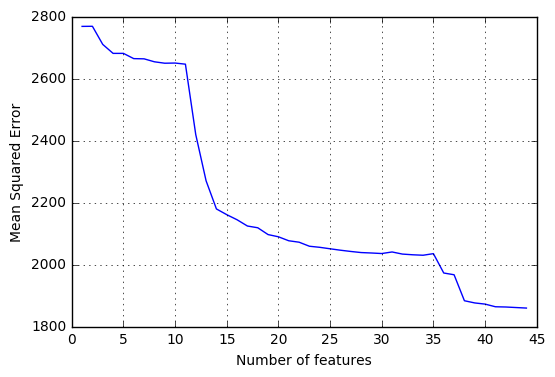

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline
mse_df = pd.DataFrame(mse_dict.items(), columns=['num_parameters','mse'], index=mse_dict.keys())
plt.plot(mse_df['mse'])
plt.grid()
plt.xlabel('Number of features')
plt.ylabel('Mean Squared Error')

In [13]:
print mse_df.ix[12:15,'mse']

12    2419.138119
13    2270.051424
14    2179.255971
15    2160.744500
Name: mse, dtype: float64


<code>
The plot of number of MSE variation with the number of features in the model shows an 'elbow graph' at num_features = 14. Less than 14 features results in drastic increase in MSE. Increasing beyond 14 features doesn't show much decrease in MSE. 
So we choose 14 as the optimal number of features for our model. These features are:
</code>

In [14]:
y_true = df['price']
X=df.ix[:, 1:]

selector = RFE(linear_reg_model, n_features_to_select=14) 
selector = selector.fit(X, y_true) 

feature_ranks = pd.DataFrame(selector.ranking_, index=df.ix[:,1:].columns, columns=['ranking'])
print feature_ranks.head() # A dataframe to store the ranking of each feature

                          ranking
Elevator in building            8
Internet                       21
Family/kid friendly             1
Wireless Internet              18
Buzzer/wireless intercom       13


In [15]:
print feature_ranks['ranking'].value_counts()[:10] #Frequency counts of ranks

1     14
15     1
2      1
3      1
4      1
5      1
6      1
7      1
8      1
9      1
Name: ranking, dtype: int64


<code>As seen above, 14 features were ranked 1 (i.e., most important)
1 feature was ranked 15
1 feature was ranked 2
and so on.
The 14 most important features are:
</code>

In [16]:
feature_ranks[feature_ranks['ranking']<2].ranking

Family/kid friendly                 1
Gym                                 1
TV                                  1
Private living room                 1
instant_bookable_f                  1
instant_bookable_t                  1
num_page_saved_H                    1
num_page_saved_L                    1
num_page_saved_M                    1
cancellation_policy_flexible        1
cancellation_policy_moderate        1
cancellation_policy_strict          1
calculated_host_listings_count_M    1
calculated_host_listings_count_S    1
Name: ranking, dtype: int64

In [17]:
# Fit model and find MSE error
cols = ['price'] + list(feature_ranks[feature_ranks['ranking']<2].index)
df_new = df.ix[:,cols]
linear_reg_model.fit(X=df_new.ix[:, 1:], y=y_true)
y_pred = linear_reg_model.predict(df_new.ix[:,1:])
print mean_squared_error(y_true, y_pred)

2179.25597108


In [18]:
df_new.shape # 14 features and 1 y-variable

(9232, 15)

<code>Randoming doing an 80:20 split of the data

In [19]:
#MSE when 80% of the data is used to obtain a model (training), tested on the rest 20%
from sklearn.model_selection import train_test_split
X = df_new.ix[:,1:]
y_true = df_new['price']
linear_reg_model = LinearRegression()
for i in range (0,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.2, random_state=i)
    linear_reg_model.fit(X_train, y_train)
    print("MSE with 80-20 split iteration %s : %0.2f" % (i+1 , mean_squared_error(y_test,linear_reg_model.predict(X_test))))
    i=i+1

MSE with 80-20 split iteration 1 : 2183.68
MSE with 80-20 split iteration 2 : 2034.44
MSE with 80-20 split iteration 3 : 2241.86
MSE with 80-20 split iteration 4 : 2173.50
MSE with 80-20 split iteration 5 : 2333.34
MSE with 80-20 split iteration 6 : 2141.23
MSE with 80-20 split iteration 7 : 2141.03
MSE with 80-20 split iteration 8 : 2187.00
MSE with 80-20 split iteration 9 : 2264.35
MSE with 80-20 split iteration 10 : 2073.01


<code>10-fold cross-validation done below.
The results are promising since the cross-validated MSE (=2183) is approximately close to the MSE when the entire data was used for both train and test (=2179).

In [21]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Randomly shuffling the records of the original data
df_new = df_new.reindex(np.random.permutation(X.index))
X = df_new.ix[:,1:]
y_true = df_new['price']

# 10-Fold CV
linear_reg_model = LinearRegression()
n_folds = 10
# negative MSE is the allowed argument for the scoring function - multiply by -1 to obtain the MSE
scores = -1.0*cross_val_score(linear_reg_model, X=X, y=y_true, cv=n_folds, scoring='neg_mean_squared_error') 
print scores
print "Average MSE from 10-fold CV:", scores.mean()

[ 2105.75823525  2027.19052507  2390.65851842  2107.07377438  2203.52185125
  2250.8725623   2128.75499734  2092.4615337   2335.18377996  2205.64189252]
Average MSE from 10-fold CV: 2184.71176702


### Residual Plots
<code>1) Plotting the histogram of error residuals
2) Plot of residuals vs X for each explanatory variable

The residuals are approximately normal distributed with mean =  -0.00356944594887


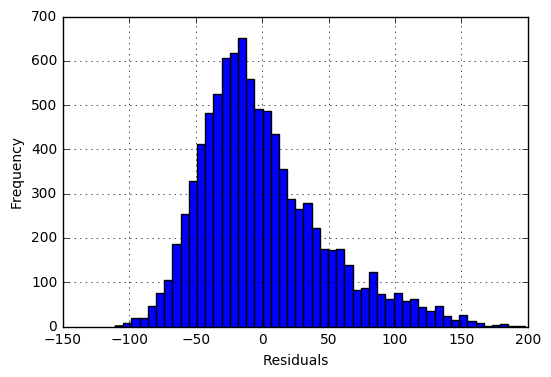

In [23]:
linear_reg_model.fit(X=df_new.ix[:,1:], y=y_true)
y_pred = linear_reg_model.predict(df_new.ix[:,1:])
residuals = y_true-y_pred
plt.hist(residuals, bins=50)
plt.grid()
plt.ylabel("Frequency")
plt.xlabel("Residuals")
print "The residuals are approximately normal distributed with mean = ", residuals.mean()

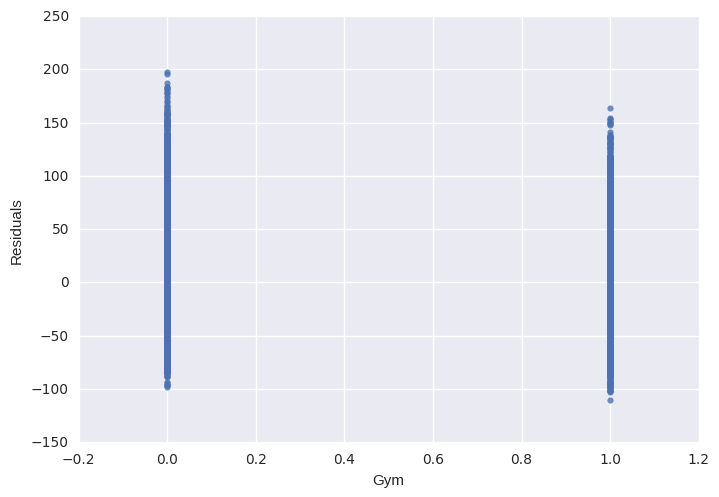

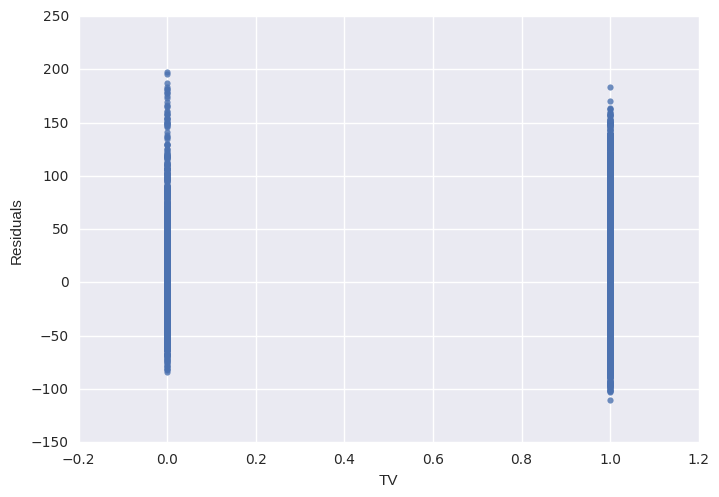

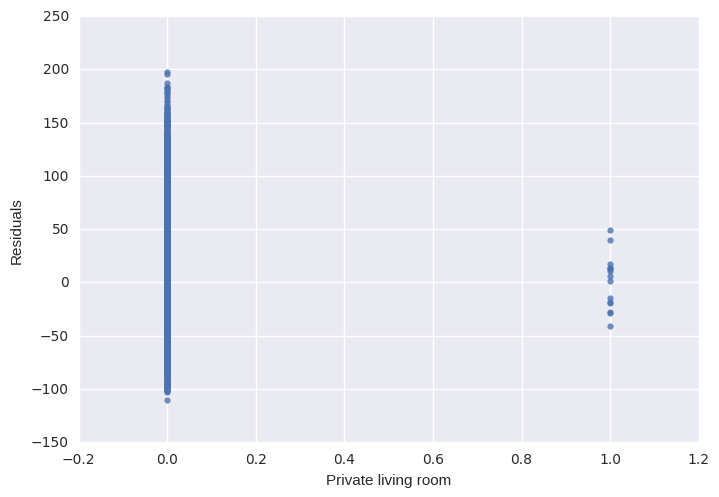

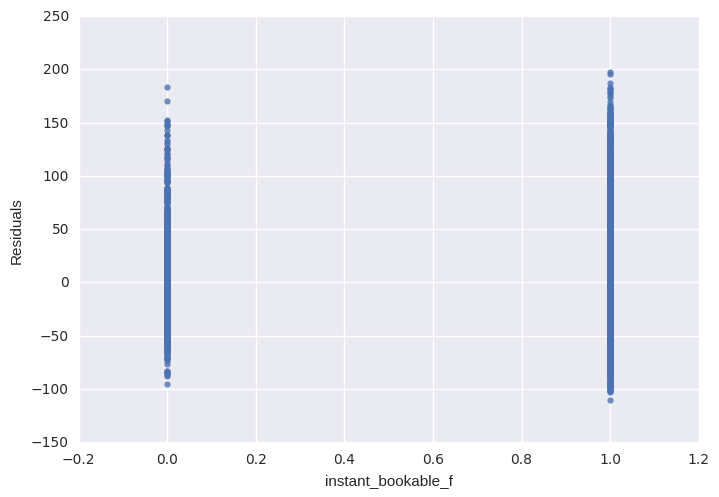

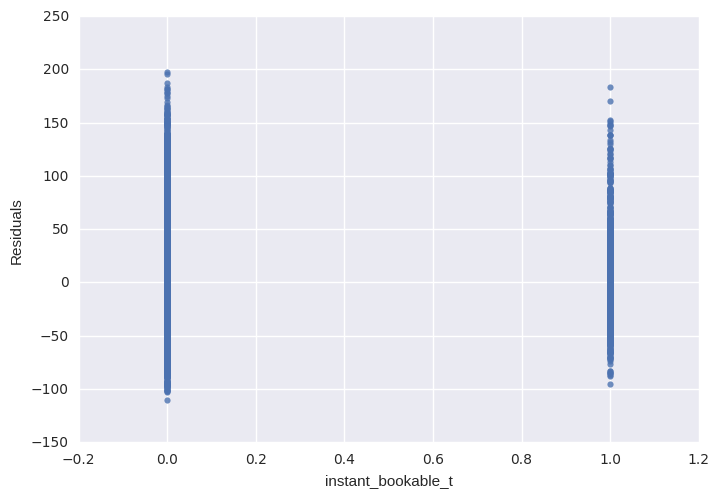

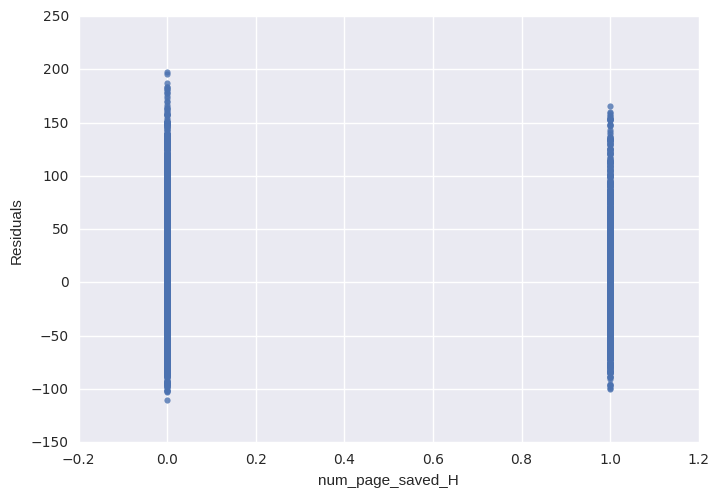

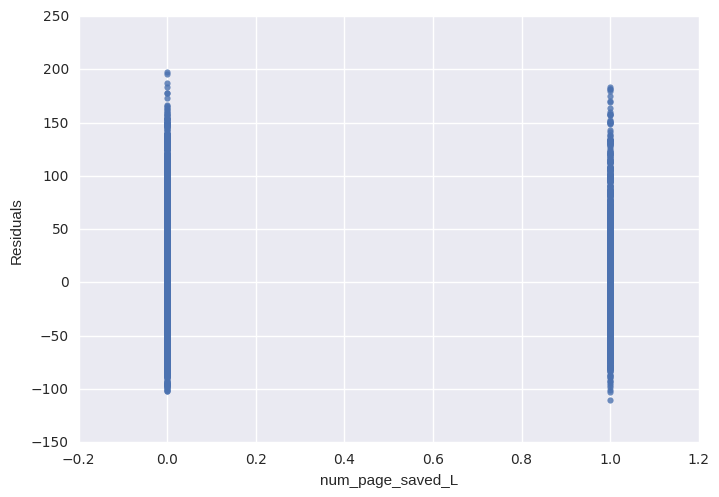

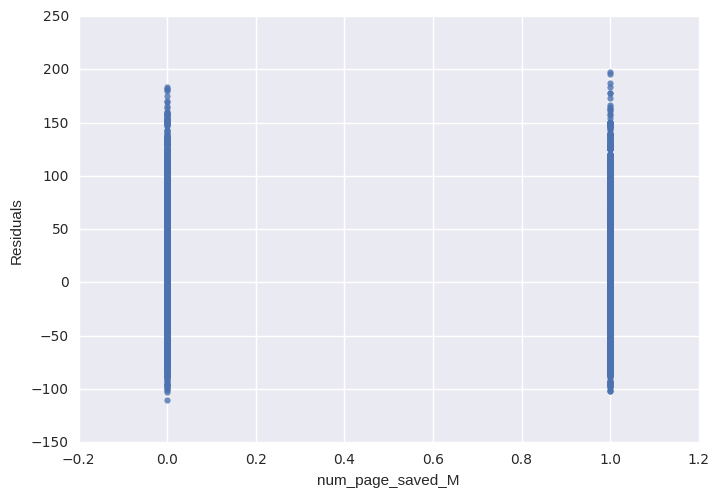

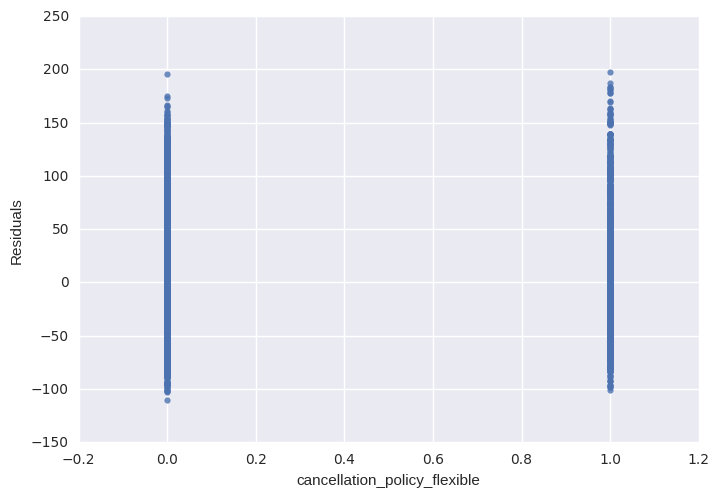

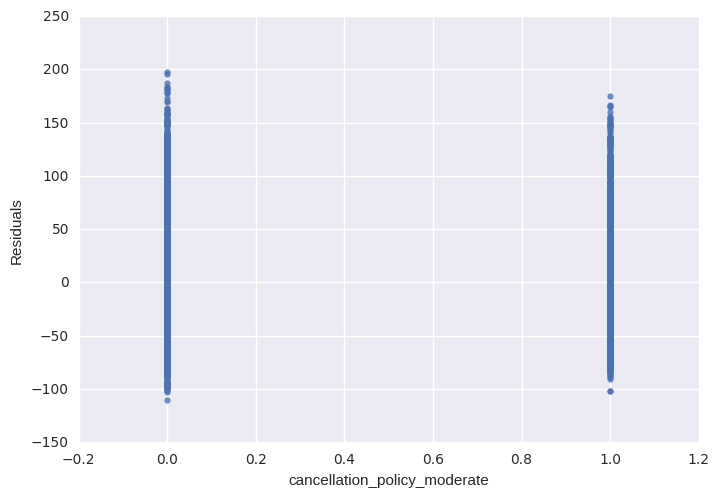

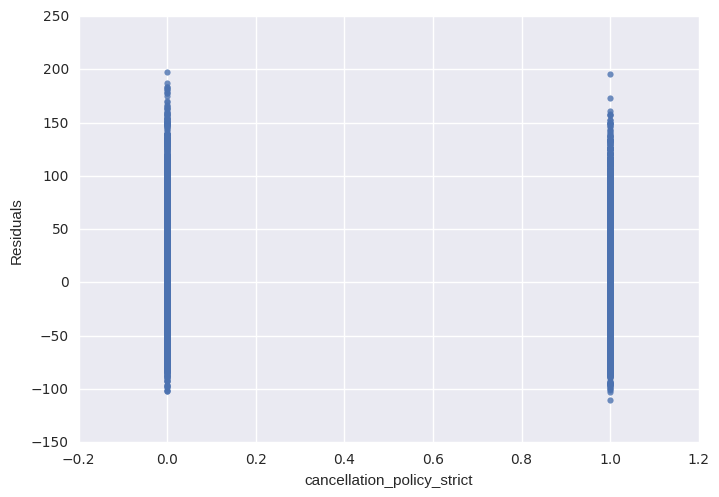

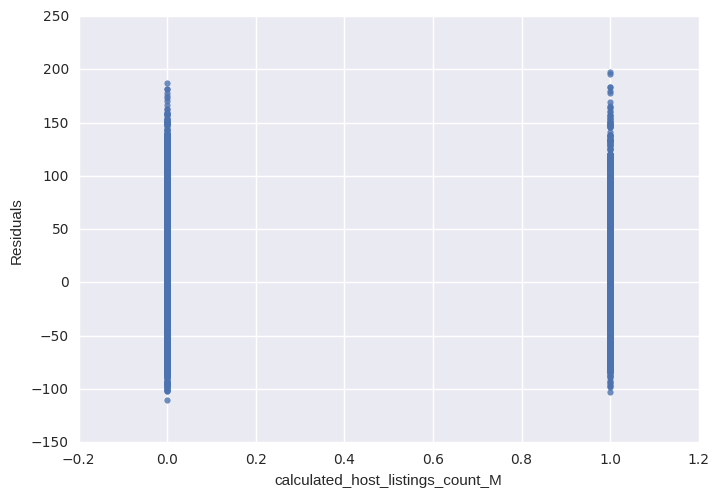

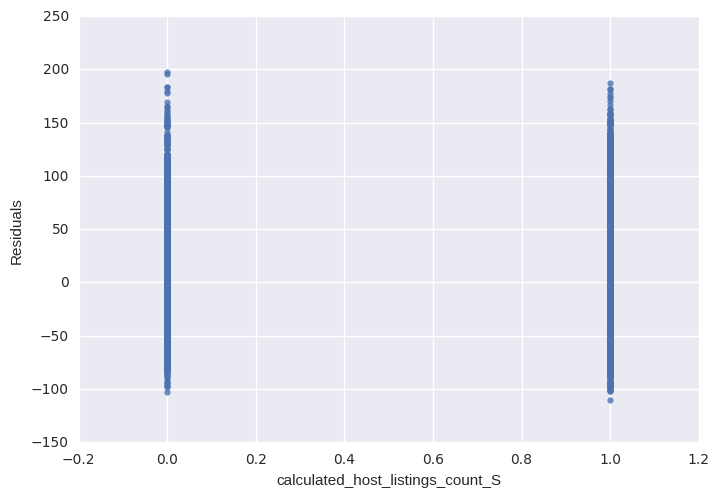

In [24]:
import seaborn as sns
features = df_new.ix[:,1:].columns[1:]
for feature in features:
    ax = sns.regplot(x=df_new[feature], y=residuals, fit_reg=False)
    ax.set(ylabel='Residuals')
    plt.show()

<code>All the variables except 'Private living room' seem to have no particular pattern in the residual plots.
'Private living room' is an amenity that is offered by very few houses listed on Airbnb. This skewed distribution of the variable 'Private living room' could be the reason for the residual plot having a less dispersed error distribution when the variable value is 1 